In [17]:
import os
import natsort
import cv2
import copy
import torch
import numpy as np
import open3d as o3d
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from moge.model.v2 import MoGeModel

from superprimitive_fusion.scanner import (
    capture_spherical_scans,
    virtual_scan,
    virtual_mesh_scan,
    mesh_depth_image,
    generate_rgbd_noise,
    clean_mesh_and_remap_weights,
)
from superprimitive_fusion.utils import (
    bake_uv_to_vertex_colours,
    polar2cartesian,
    distinct_colours,
)
from superprimitive_fusion.mesh_fusion import (
    fuse_meshes,
)
from superprimitive_fusion.mesh_fusion_utils import (
    get_mesh_components,
)

device = torch.device("cuda:0")

In [18]:
def plot_images(images, max_cols=5, titles=None, per_img_width=3, cmap=None, cbar_cols=None, cbar_kw=None):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    n = len(images)
    h_to_w = images[0].shape[0] / images[0].shape[1]
    cols = max(1, min(max_cols, n))
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols*per_img_width, rows*per_img_width*h_to_w), squeeze=False)
    axes = axes.ravel()
    for i, ax in enumerate(axes):
        if i >= n: ax.axis('off'); continue
        img = images[i]
        arr = plt.imread(img) if isinstance(img, (str, os.PathLike)) else np.asarray(img)
        im = ax.imshow(arr, cmap=(cmap if arr.ndim == 2 else None))
        ax.set_xticks([]); ax.set_yticks([])
        for s in ax.spines.values(): s.set_visible(False)
        if titles and i < len(titles) and titles[i]: ax.set_title(titles[i], fontsize=9, pad=2)
        if arr.ndim == 2 and cbar_cols and (i % cols) in cbar_cols:
            cax = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.02)
            fig.colorbar(im, cax=cax, **(cbar_kw or {}))
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
    return fig, axes[:n]


In [19]:
model = MoGeModel.from_pretrained("../models/MoGe/moge-2-vitl-normal.pt").to(device)                       

In [20]:
rgb_rt = '../data/replica_room_0/imap/01/rgb/'
depth_rt = '../data/replica_room_0/imap/01/depth/'
sem_c_rt = '../data/replica_room_0/imap/01/semantic_class/'
sem_i_rt = '../data/replica_room_0/imap/01/semantic_instance/'

rgb_names = np.asarray(natsort.natsorted(os.listdir(rgb_rt)))
depth_names = np.asarray(natsort.natsorted(os.listdir(depth_rt)))
sem_c_names = np.asarray(natsort.natsorted(os.listdir(sem_c_rt)))
sem_i_names = np.asarray(natsort.natsorted(os.listdir(sem_i_rt)))

shuffle_mask = np.arange(rgb_names.shape[0])
np.random.shuffle(shuffle_mask)

N = 16
pairs = []
for i in range(N):
    rgb_name = rgb_rt + rgb_names[shuffle_mask][i]
    depth_name = depth_rt + depth_names[shuffle_mask][i]
    sem_c_name = sem_c_rt + sem_c_names[shuffle_mask][i]
    sem_i_name = sem_i_rt + sem_i_names[shuffle_mask][i]
    
    rgb = plt.imread(rgb_name)
    depth = plt.imread(depth_name)
    sem_c = plt.imread(sem_c_name)
    sem_i = plt.imread(sem_i_name)
    

    pairs.append({'rgb':rgb, 'depth_gt':depth, 'sem_i':sem_i, 'sem_c':sem_c})

In [21]:
for pair in pairs:
    input_image = torch.tensor(pair['rgb'].copy(), dtype=torch.float32, device=device).permute(2, 0, 1)

    output = model.infer(input_image)

    pair['depth_pred'] = output['depth'].squeeze().cpu().numpy()

In [15]:
for pair in pairs:
    dpr = pair['depth_pred']
    dgt = pair['depth_gt']
    # print(f'pred median: {np.median(dpr/(dpr.max()))}')
    print(f'pred median: {np.median(pair['depth_pred'])}')
    print(f'gt median: {np.median(dgt/(dgt.max()))}')
    # print(f'ratio: {np.median(pair['depth_pred'])/np.median(pair['depth_gt'])}')
    print()

pred median: 2.0940167903900146
gt median: 0.364529550075531

pred median: 2.755852222442627
gt median: 0.5819411873817444

pred median: 2.7469873428344727
gt median: 0.49062809348106384

pred median: 2.0548818111419678
gt median: 0.3696088194847107

pred median: 3.011352300643921
gt median: 0.5743139982223511

pred median: 2.7032299041748047
gt median: 0.4748189449310303

pred median: 3.214512825012207
gt median: 0.5044220685958862

pred median: 3.122370719909668
gt median: 0.5312728881835938

pred median: 2.7018399238586426
gt median: 0.5271766781806946

pred median: 3.007362127304077
gt median: 0.5321508049964905

pred median: 2.5121026039123535
gt median: 0.5585049986839294

pred median: 2.9030990600585938
gt median: 0.6848719716072083

pred median: 3.1217358112335205
gt median: 0.5658783912658691

pred median: 3.169881582260132
gt median: 0.4854147732257843

pred median: 2.6914303302764893
gt median: 0.7639979124069214

pred median: 2.679307460784912
gt median: 0.4417664408683777


In [22]:
images = []
depth_errors = []
for pair in pairs:
    rgb = pair['rgb']
    depth_gt = pair['depth_gt'].copy()
    depth_pr = pair['depth_pred'].copy()

    lgd_gt = np.log(depth_gt)
    lgd_pr = np.log(depth_pr)

    depth_pr_ = np.exp(lgd_pr - np.nanmedian(lgd_pr - lgd_gt))
    depth_er = depth_pr_ - depth_gt
    
    depth_er[depth_gt==0] = 0
    
    pair['depth_er'] = depth_er
    depth_errors.append(depth_er)

    images.extend([rgb, depth_gt, depth_pr, depth_er])

/tmp/ipykernel_154498/2712604939.py:8: RuntimeWarning: divide by zero encountered in log
  lgd_gt = np.log(depth_gt)


(<Figure size 1600x453.333 with 12 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >], dtype=object))

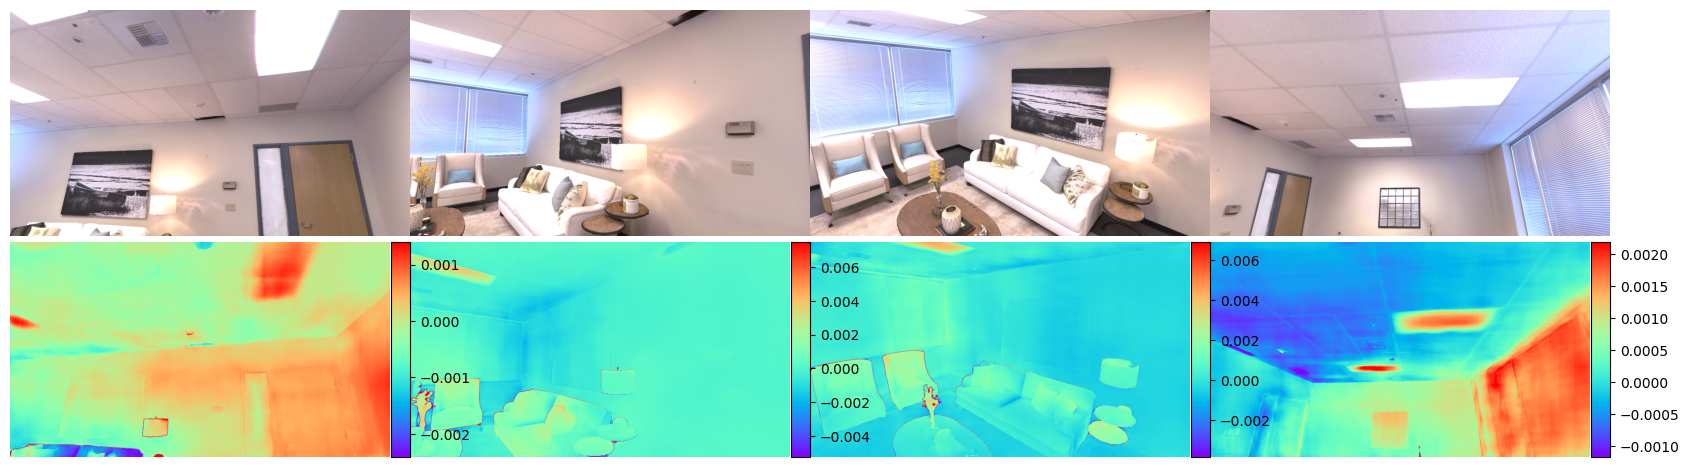

In [10]:
r = (0.1,99.9)
depth_errors_clipped = [np.clip(depth_error, np.percentile(depth_error, r[0]), np.percentile(depth_error, r[1])) for depth_error in depth_errors]
to_plot = [
    images[0],
    images[4],
    images[8],
    images[12],
    depth_errors_clipped[0],
    depth_errors_clipped[1],
    depth_errors_clipped[2],
    depth_errors_clipped[3]
]
# plot_images(depth_errors_clipped, max_cols=4, per_img_width=4, cbar_cols=[0,1,2,3], cmap='rainbow')
plot_images(to_plot, max_cols=4, per_img_width=4, cbar_cols=[0,1,2,3], cmap='rainbow')

Text(0, 0.5, 'Depth Error')

<Figure size 700x300 with 0 Axes>

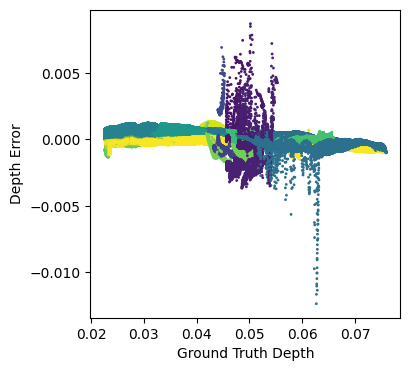

In [ ]:
max_cols = 4
per_img_width = 4

# n = len(pairs)
n = 1
cols = max(1, min(max_cols, n))
rows = (n + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(cols*per_img_width, rows*per_img_width), squeeze=False)
axes = axes.ravel()
for i, ax in enumerate(axes):
    if i >= n: ax.axis('off'); continue
    pair = pairs[i]

    depth_gt = pair['depth_gt']
    depth_er = pair['depth_er']
    sem_i = pair['sem_i']
    sem_i_norm = (sem_i - sem_i.min()) / (sem_i.max() - sem_i.min())

    ax.scatter(depth_gt[depth_gt!=0], depth_er[depth_gt!=0], c=sem_i_norm[depth_gt!=0], s=1)

plt.xlabel('Ground Truth Depth')
plt.ylabel('Depth Error')

(np.float64(-0.5), np.float64(1199.5), np.float64(679.5), np.float64(-0.5))

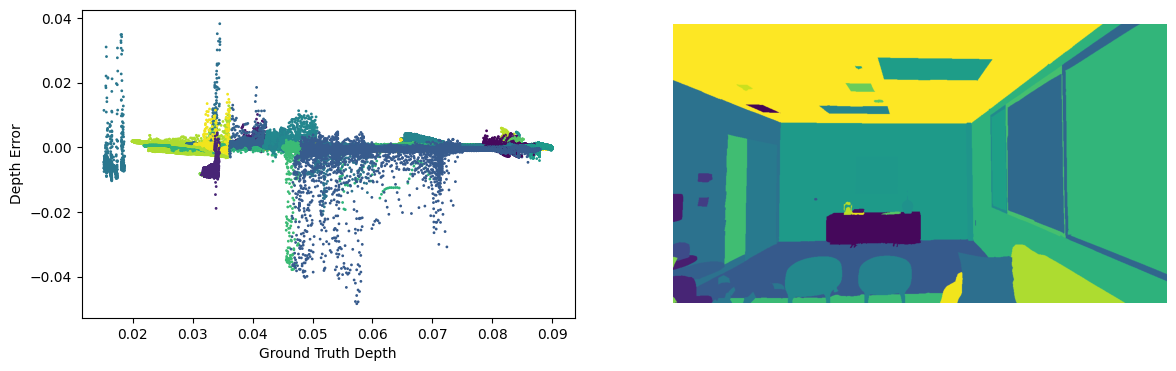

In [28]:
i = 4
pair = pairs[i]

depth_gt = pair['depth_gt']
depth_er = pair['depth_er']
sem_i = pair['sem_i']
sem_i_norm = (sem_i - sem_i.min()) / (sem_i.max() - sem_i.min())

fig, axes = plt.subplots(1, 2, figsize=(14,4))
axes[0].scatter(depth_gt[depth_gt!=0], depth_er[depth_gt!=0], c=sem_i_norm[depth_gt!=0], s=1)
axes[0].set_xlabel('Ground Truth Depth')
axes[0].set_ylabel('Depth Error')

axes[1].imshow(sem_i)
plt.axis('off')

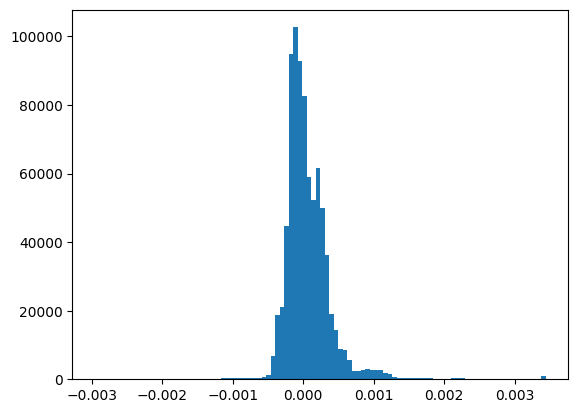

In [127]:
r = (0.01,99.9)
img = depth_errors[0]
img = np.clip(img, np.percentile(img, r[0]), np.percentile(img, r[1]))
_=plt.hist(img.reshape(-1),bins=100)

In [293]:
R_range = (0.5, 1.2)
lat_range = (45, 80)
lon_range = (0, 360)
N = 6
rad = np.random.rand(N) * (R_range[1]-R_range[0]) + R_range[0]
lat = np.random.rand(N) * (lat_range[1]-lat_range[0]) + lat_range[0]
lon = np.random.rand(N) * (lon_range[1]-lon_range[0]) + lon_range[0]
pairs = []
for i in range(N):
    cc = cam_offset + polar2cartesian(r=rad[i], lat=lat[i], long=lon[i])
    scan_result = virtual_scan(
        gt_mesh_list,
        cc,
        look_at,
        width_px=width,
        height_px=height,
        fov=fov,
        up=[0,0,1],
    )

    look_dir = (look_at - cc) / np.linalg.norm(look_at - cc)

    verts_gt = np.flip(scan_result['verts'], axis=0)
    rgb = np.flip(scan_result['vcols'], axis=0)
    normals_gt = np.flip(scan_result['norms'], axis=0)


    rho_gt = np.linalg.norm(verts_gt - cc, axis=2)
    depth_gt = (verts_gt - cc) @ look_dir


    pairs.append(
        {'rgb':rgb,
         'rho_gt':rho_gt,
         'depth_gt':depth_gt,
         'verts_gt':verts_gt,
         'normals_gt':normals_gt,
         'cam_centre':cc,
         'look_dir':look_dir}
    )

/tmp/ipykernel_224714/2408984715.py:29: RuntimeWarning: invalid value encountered in matmul
  depth_gt = (verts_gt - cc) @ look_dir


In [294]:
for pair in pairs:
    cc = pair['cam_centre']
    verts_gt = pair['verts_gt']
    depth_gt = pair['depth_gt']

    input_image = torch.tensor(pair['rgb'].copy(), dtype=torch.float32, device=device).permute(2, 0, 1)
    output = model.infer(input_image)

    depth_pred = output['depth'].squeeze().cpu().numpy()  # ensure (H, W)

    ray = verts_gt - cc
    rho_gt = np.linalg.norm(ray, axis=2)
    ray_hat = ray / (rho_gt[..., None] + 1e-12)

    cos_theta = depth_gt / np.maximum(rho_gt, 1e-12)
    rho_pred = depth_pred / np.clip(cos_theta, 1e-3, 1.0)
    verts_pred = cc + rho_pred[..., None] * ray_hat

    pair['rho_pred'] = rho_pred
    pair['verts_pred'] = verts_pred
    pair['depth_pred'] = depth_pred

/tmp/ipykernel_224714/1383586561.py:13: RuntimeWarning: invalid value encountered in divide
  ray_hat = ray / (rho_gt[..., None] + 1e-12)
/tmp/ipykernel_224714/1383586561.py:15: RuntimeWarning: invalid value encountered in divide
  cos_theta = depth_gt / np.maximum(rho_gt, 1e-12)


In [295]:
for pair in pairs:
    verts_pred = pair['verts_pred'].reshape(-1, 3)
    valid_verts_pred = verts_pred[np.isfinite(verts_pred).all(axis=1)]
    verts_gt = pair['verts_gt'].reshape(-1, 3)
    valid_verts_gt = verts_gt[np.isfinite(verts_gt).all(axis=1)]

    pcd1 = o3d.geometry.PointCloud()
    pcd1.points = o3d.utility.Vector3dVector(valid_verts_pred)
    pcd1.paint_uniform_color([0.8, 0, 0.5])

    pcd2 = o3d.geometry.PointCloud()
    pcd2.points = o3d.utility.Vector3dVector(valid_verts_gt)
    pcd2.paint_uniform_color([0, 0.8, 0.5])

    o3d.visualization.draw_geometries([pcd1, pcd2])


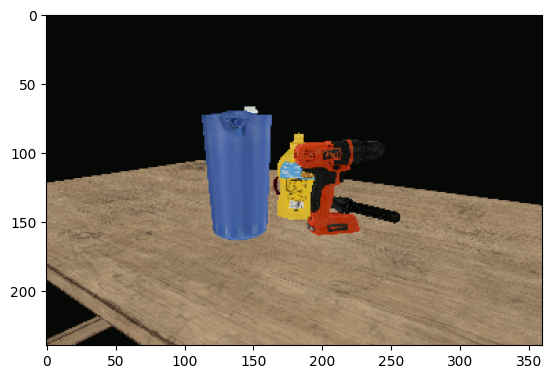

In [296]:
plt.imshow(rgb)

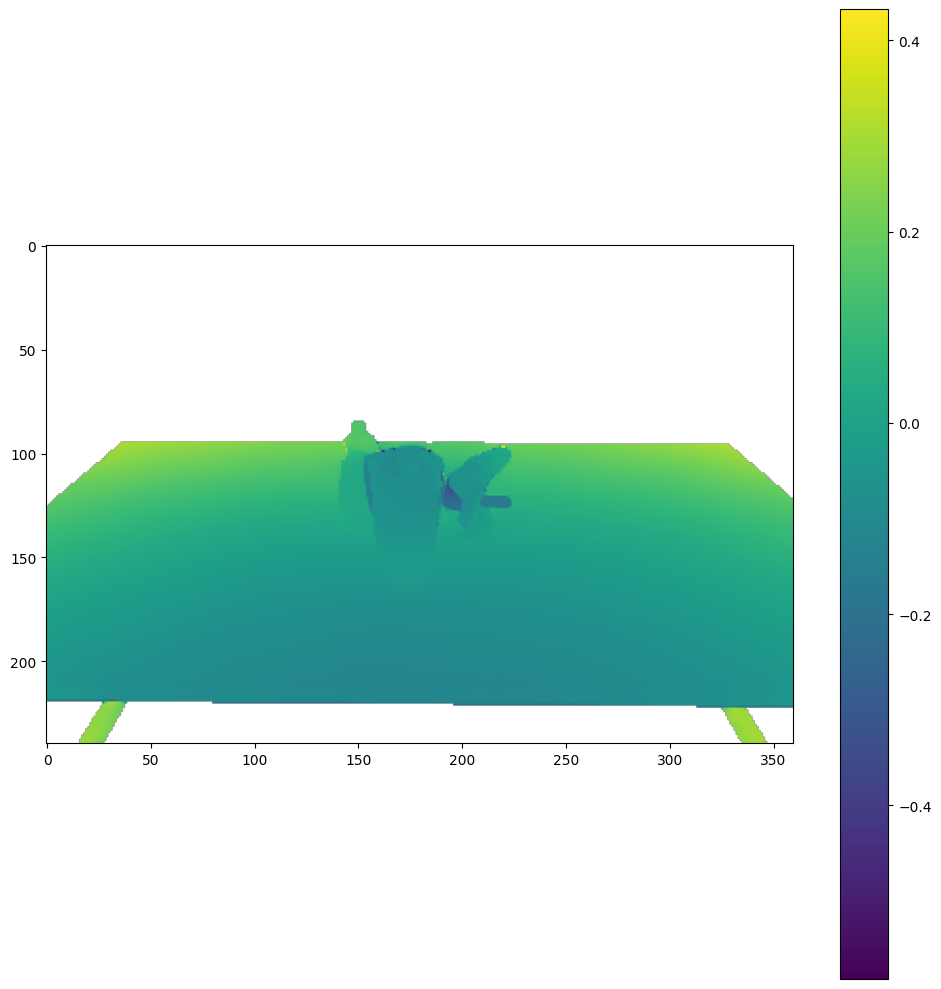

In [298]:
pair = pairs[4]
e = pair['rho_pred'] - pair['rho_gt']
r = e - e[np.isfinite(e)].mean()
# plt.hist(r[np.isfinite(r)], bins=30)
plt.figure(figsize=(10,10))
plt.imshow(r)
plt.colorbar()
plt.tight_layout()

/tmp/ipykernel_224714/644784302.py:7: RuntimeWarning: invalid value encountered in subtract
  ax.imshow(pair['depth_pred'] - pair['depth_gt'])


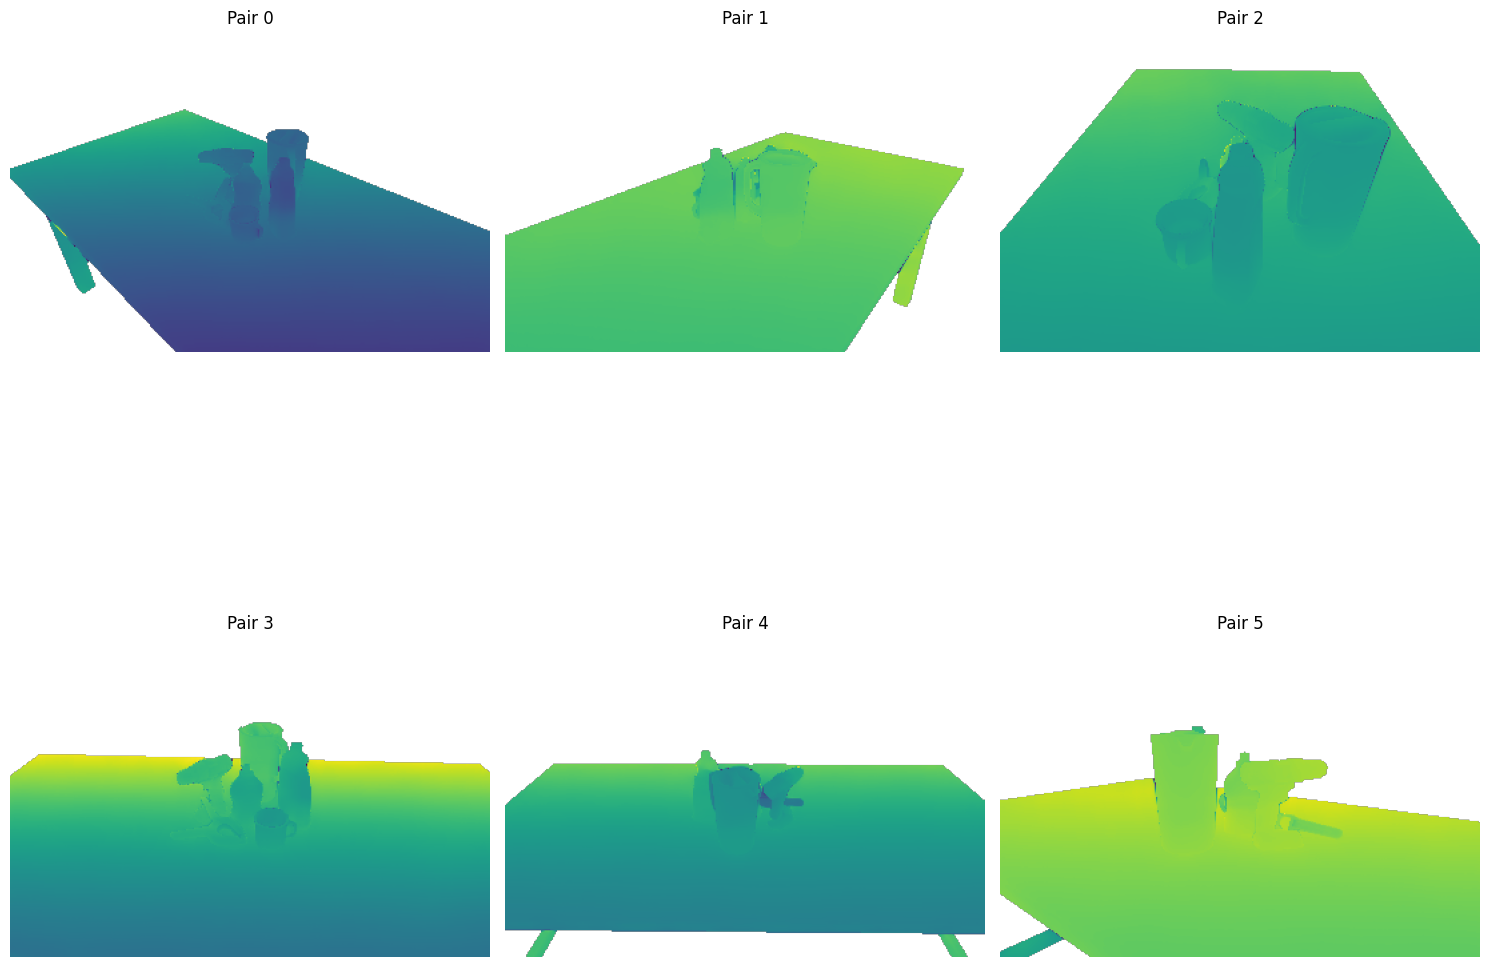

In [308]:
fig, axes = plt.subplots(2,3, figsize=(15, 15))  # 3 rows, 2 columns
axes = axes.flatten()  # easier indexing

for i in range(N):
    pair = pairs[i]
    ax = axes[i]
    ax.imshow(pair['depth_pred'] - pair['depth_gt'])
    ax.set_title(f'Pair {i}')
    ax.axis('off')

plt.tight_layout()
plt.show()